# Loading the database in Julia

In [1]:
using SQLite
using NPZ
using Images
using Plots

In [87]:
db = SQLite.DB("pix2.sqlite")

SQLite.DB("pix2.sqlite")

In [98]:
res = SQLite.query(db,"select W,pic from static order by random() limit 10") |> DataFrame;

┌ Warning: `SQLite.query(db, sql)` will return an `SQLite.Query` object in the future; to materialize a resultset, do `DataFrame(SQLite.query(db, sql))` instead
│   caller = ip:0x0
└ @ Core :-1
┌ Warning: `SQLite.Source(db, sql)` is deprecated in favor of `SQLite.Query(db, sql)` which executes a query and returns a row iterator
│   caller = ip:0x0
└ @ Core :-1


SQLite returns DataFrames that have named fields (but raises a deprecation warning that we have to do it explicitly.)

The results are serialized Numpy arrays:

In [102]:
blob1 = res.pic[2];
img = NPZ.npzreadarray(IOBuffer(blob1));

We can use the Images call,

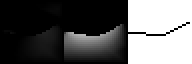

In [103]:
colorview(Gray,hcat([img[:,:,i] for i in 1:3]...))

or the heatmap call to look at them:

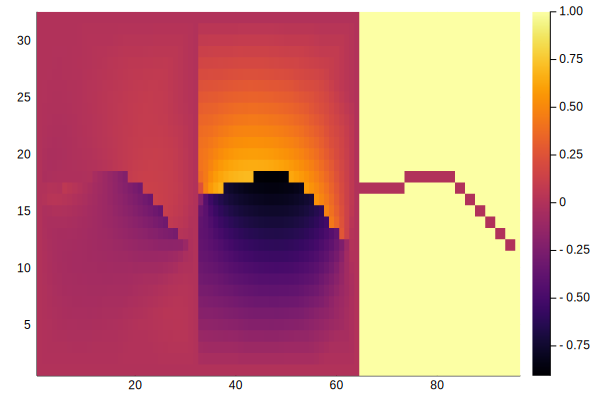

In [104]:
heatmap(hcat([img[:,:,i] for i in 1:3]...))

# Training an autoencoder



In [8]:
using Flux

In [9]:
images_frame = SQLite.query(db,"select pic from static") |> DataFrame;

┌ Warning: `SQLite.query(db, sql)` will return an `SQLite.Query` object in the future; to materialize a resultset, do `DataFrame(SQLite.query(db, sql))` instead
│   caller = ip:0x0
└ @ Core :-1
┌ Warning: `SQLite.Source(db, sql)` is deprecated in favor of `SQLite.Query(db, sql)` which executes a query and returns a row iterator
│   caller = ip:0x0
└ @ Core :-1


Read and cat together all of the images into one giant 4D array.

In [10]:
images_array = cat([NPZ.npzreadarray(IOBuffer(blob)) for blob in images_frame.pic]...,dims=4);

In [12]:
size(images_array,4)

1182

In [72]:
size(slices)

(1182,)

In [74]:
map(size,minibatches)

12-element Array{Tuple{Int64,Int64},1}:
 (1024, 100)
 (1024, 100)
 (1024, 100)
 (1024, 100)
 (1024, 100)
 (1024, 100)
 (1024, 100)
 (1024, 100)
 (1024, 100)
 (1024, 100)
 (1024, 100)
 (1024, 82) 

In [13]:
slices = [ reshape(images_array[:,:,3,i],(:,)) for i=1:size(images_array,4) ]
minibatches = [ cat(imgs...,dims=2) for imgs in Iterators.partition(slices,100) ]

12-element Array{Array{Float32,2},1}:
 [1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0; … ; 1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0]
 [1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0; … ; 1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0]
 [1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0; … ; 1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0]
 [1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0; … ; 1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0]
 [1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0; … ; 1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0]
 [1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0; … ; 1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0]
 [1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0; … ; 1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0]
 [1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0; … ; 1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0]
 [1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0; … ; 1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0]
 [1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0; … ; 1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0]
 [1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0; … ; 1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0]
 [1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0; … ; 1.0 1.0 … 1.0 1.

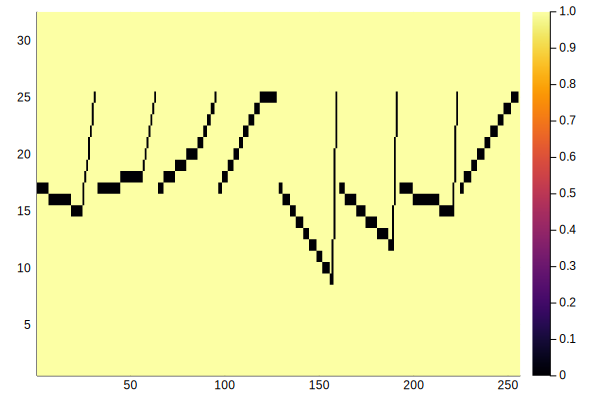

In [14]:
heatmap(hcat([images_array[:,:,3,i] for i in 1175:1182]...))

In [141]:
picw = size(images_array,1)
N_latent = 4
encoder = Dense(picw^2, N_latent)
decoder = Dense(N_latent, picw^2)
m = Chain(encoder, decoder)
loss(x) = Flux.mse(m(x),x)

loss (generic function with 1 method)

In [142]:
function side_by_side(x)
    hcat( reshape(x,(32,32) ), reshape(Flux.data(m(x)), (32,32)))
end
function side_by_side_stack(xs)
    vcat([
        hcat( reshape(x,(32,32) ), reshape(Flux.data(m(x)), (32,32)))
            for x in xs ]...
    )
end

side_by_side_stack (generic function with 1 method)

In [148]:
evalcb = Flux.throttle(() -> @show(loss(minibatches[2])), 1.0)
opt = ADAM()

Flux.@epochs 100 Flux.train!(loss, params(m), zip(minibatches), opt, cb = evalcb)

┌ Info: Epoch 1
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105


loss(minibatches[2]) = 0.026404805f0 (tracked)


┌ Info: Epoch 2
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 3
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 4
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 5
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 6
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 7
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 8
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 9
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 10
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 11
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 12
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 13
└

loss(minibatches[2]) = 0.010472069f0 (tracked)


┌ Info: Epoch 15
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 16
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 17
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 18
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 19
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 20
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 21
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 22
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 23
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 24
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 25
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Ep

loss(minibatches[2]) = 0.010936763f0 (tracked)


┌ Info: Epoch 29
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 30
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 31
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 32
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 33
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 34
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 35
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 36
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 37
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 38
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 39
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Ep

loss(minibatches[2]) = 0.010268807f0 (tracked)


┌ Info: Epoch 42
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 43
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 44
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 45
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 46
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 47
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 48
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 49
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 50
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 51
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 52
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Ep

loss(minibatches[2]) = 0.010419581f0 (tracked)


┌ Info: Epoch 55
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 56
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 57
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 58
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 59
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 60
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 61
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 62
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 63
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 64
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 65
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Ep

loss(minibatches[2]) = 0.01033855f0 (tracked)


┌ Info: Epoch 69
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 70
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 71
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 72
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 73
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 74
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 75
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 76
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 77
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 78
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 79
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Ep

loss(minibatches[2]) = 0.009719127f0 (tracked)


┌ Info: Epoch 82
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 83
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 84
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 85
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 86
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 87
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 88
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 89
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 90
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 91
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 92
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Ep

loss(minibatches[2]) = 0.009698681f0 (tracked)


┌ Info: Epoch 97
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 98
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 99
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105
┌ Info: Epoch 100
└ @ Main /Users/afq/.julia/packages/Flux/lz7S9/src/optimise/train.jl:105


Now we can pick 10 random examples and compare the autoencoded image to the original:

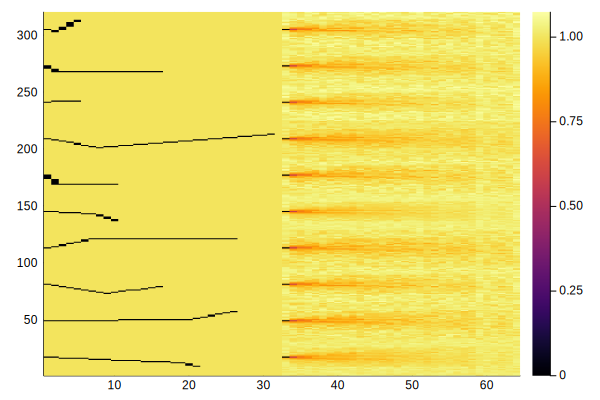

In [149]:
side_by_side_stack([ reshape(slices[i], (:,1) ) 
        for i in rand(1:size(slices,1),(10,)) ]) |> heatmap

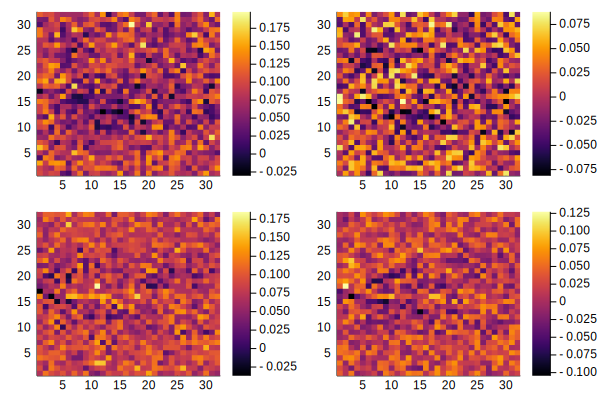

In [150]:
unitvec(i) = Array{Float32}(Flux.onehot(i,1:4))
plot([heatmap(reshape(Flux.data(decoder(reshape(unitvec(i),(:,1)))),(32,32))) for i in [1,2,3,4]]...)

In [137]:
unitvec(i) = Array{Float32}(Flux.onehot(i,1:4))


unitvec (generic function with 1 method)

In [138]:
[unitvec(i) for i in [1,2,3,4]]

4-element Array{Array{Float32,1},1}:
 [1.0, 0.0, 0.0, 0.0]
 [0.0, 1.0, 0.0, 0.0]
 [0.0, 0.0, 1.0, 0.0]
 [0.0, 0.0, 0.0, 1.0]